In [1]:
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
import yfinance as yf
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
# pyfolio  qgrid empyrical
import pickle
import numpy as np
import time

import seaborn as sns
from itertools import combinations
import multiprocessing as mp
from tqdm import tqdm
import sys

import TradingRefact as td 
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

# Função Modelo

In [3]:
def estrategia_mmovel(serie,longmean=100,shortmean=10):
    #Recebe Uma série de preços de Fechamento
    serie =pd.DataFrame(serie)

    


    #Marca o cruzamento da média longa com a média Curta
    serie['roll']   =  serie.rolling(shortmean,min_periods=5).mean()-serie.rolling(longmean,min_periods=5).mean()
    

    serie['DECISAO']=np.nan
    #0 significa compra 1 Significa Fazer nada, 0 significa compra pois é util em uma função futura,venda poderia ser -1
    serie.loc[serie['roll']>0.0,'DECISAO']=0
    serie.loc[serie['roll']<=0.0,'DECISAO'] =1

In [4]:
with open('C:\\Users\\Rafael\\Trading\\Trading\\ibov.pkl','rb') as file:
     data =pickle.load(file)
data1 =data['Adj Close']
data1.drop('MGLU3.SA',axis=1,inplace=True)

C:\Users\Rafael\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [11]:
%%timeit

mmovel=td.estrategia_mmovel(data1['ABEV3.SA']) 

6.5 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:

mmovel=td.estrategia_mmovel(data1['ABEV3.SA'])

### É lenta devido ao uso do pandas,0.5S para calcular o resultado para o IBOV

In [6]:
def troca_posicao(x):
    #Função que marca quando se altera a posição de nada para comprado ou vice versa
    x['DECISAO_1'] =  x['DECISAO'].shift(1)
    filtro=(x['DECISAO']!=x['DECISAO_1'])
    
    x['ESTRAT']=np.nan 
    x.loc[filtro,'ESTRAT']=x.loc[filtro,'DECISAO']

In [23]:
%%timeit
mmovel1=td.troca_posicao(mmovel)

2.2 ms ± 63.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#Sem Stress de performance Aqui

In [20]:
def calculate_returns(x):
    
    x['DAILY_CHANGE']=np.nan
    #Simples Variação Diária   
    x['DAILY_CHANGE']= x.iloc[:,0]/x.iloc[:,0].shift(1)
    #Seleciona as trocas de  posições 
    trocas=x['ESTRAT']==0
    
    #Seciona todas as posições
    comprado=x['DECISAO']==0
    
    
    #x.loc[comprado,'TOTAL_CHANGE']=np.cumprod(x.loc[comprado,'DAILY_CHANGE'].values)
    #Prenche a variação Diária Somente para aqueles onde temos posição
    x.loc[:,'DAILY_CHANGE']=x.loc[comprado,'DAILY_CHANGE']
    #Onde se trocou de posição ainda não há rendimento  então 0% de variação
    x.loc[trocas,'DAILY_CHANGE']=1
    
    return x 

In [30]:
%%timeit
mmovel2=td.calculate_returns(mmovel1)

2.81 ms ± 7.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#Sem Stress de performance Aqui

In [26]:
def stop_loss(x,stop):
    #É um gato, mas funciona
    #Soma acumulada da decisão == 0 quando se esta comprado,então autoamticamente cada compra ganhya um codigo
    x['SUM']=x['DECISAO'].cumsum()
    #Calcula o resultado dentro de cada operação
    x["OP_RESULT"]=x[x['DECISAO']==0].groupby(['SUM'])['DAILY_CHANGE'].cumprod()
    #filtro para operações abaixo do stop
    f=x['OP_RESULT']<stop
    #pega a primeira data onde aquela operação entrou em stop   
    f=x[f]['SUM'].reset_index().groupby(['SUM']).min()
    #cria um filtro para todas as datas subsequentes dentro da mesma operação
    f=pd.DataFrame(index=x.SUM).join(f)
    #filtra as operações que entrata em stop
    x=x[~(x.index>=f['Date']) &( f.index==x.SUM)]
    return x

In [31]:
%%timeit
mmovel3=td.stop_loss(mmovel2,0.95)

7.91 ms ± 177 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Estupidamente lenta para uma função que é só o stop

# Como eu vou usar

In [48]:
%%timeit
#Chama a função Sequencialmente,cria um DF do ibovespa e constrói Um dataFrame

results=[td.stop_loss(td.calculate_returns(td.troca_posicao(td.estrategia_mmovel(data1[x]))),0.95) for  x in  data1.columns ]
results=pd.concat( results,axis=1)

1.68 s ± 18.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
results=[td.stop_loss(td.calculate_returns(td.troca_posicao(td.estrategia_mmovel(data1[x],200,50))),0.95) for  x in  data1.columns ]
results=pd.concat( results,axis=1)

In [53]:
results.columns=pd.MultiIndex.from_tuples([i for i in zip(sorted(data1.columns.tolist()*8),results.columns)])

In [54]:
results.head()

ABEV3.SA                                                           \
           ABEV3.SA roll DECISAO DECISAO_1 ESTRAT DAILY_CHANGE SUM OP_RESULT   
Date                                                                           
2010-04-05      NaN  NaN     NaN       NaN    NaN          NaN NaN       NaN   
2010-04-06      NaN  NaN     NaN       NaN    NaN          NaN NaN       NaN   
2010-04-07      NaN  NaN     NaN       NaN    NaN          NaN NaN       NaN   
2010-04-08      NaN  NaN     NaN       NaN    NaN          NaN NaN       NaN   
2010-04-09      NaN  NaN     NaN       NaN    NaN          NaN NaN       NaN   

           AZUL4.SA       ... ^BVSP              ^N225                         \
           AZUL4.SA roll  ...   SUM OP_RESULT BPAN4.SA roll DECISAO DECISAO_1   
Date                      ...                                                   
2010-04-05      NaN  NaN  ...  46.0       NaN      NaN  NaN     NaN       NaN   
2010-04-06      NaN  NaN  ...  46.0  1.000000      NaN  NaN     NaN       NaN   
2010-04-07      NaN  NaN  ...  46.0  1.000932      NaN  NaN     NaN       NaN   
2010-04-08      NaN  NaN  ...  46.0  0.989885      NaN  NaN     NaN       NaN   
2010-04-09      NaN  NaN  ...  46.0  0.993088      NaN  NaN     NaN       NaN   

                                              
           ESTRAT DAILY_CHANGE SUM OP_RESULT  
Date                                          
2010-04-05    NaN          NaN NaN       NaN  
2010-04-06    NaN          NaN NaN       NaN  
2010-04-07    NaN          NaN NaN       NaN  
2010-04-08    NaN          NaN NaN       NaN  
2010-04-09    NaN          NaN NaN       NaN  

[5 rows x 592 columns]

# Como Calcular o Retorno Dessa Carteira?

In [59]:
%%timeit
#Seleciona todos os retornos diários
retornos =results.loc[:,(slice(None),'DAILY_CHANGE')]
#Calcula o divisor da carteira,qts ações estão nela, E lembra o fato que trocamos o rendimento do primeiro ponto por 1? é para corrigir esse calculo
pesos=pd.notnull(retornos).sum(axis=1)
#Soma das colunas pelos divisor e o produto cumularivo dos resultados
retorno=pd.Series(np.cumprod((retornos.sum(axis=1)/pesos).fillna(1).values),index=retornos.index)

4.29 ms ± 53.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


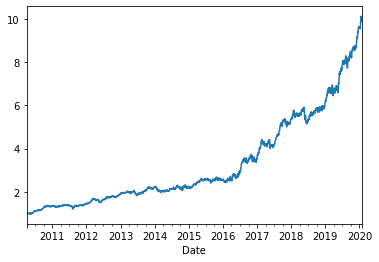

In [58]:
retorno.plot()

## A partir disso Criamos uma função Worker

In [60]:
def worker(x):
    with open('C:\\Users\\Rafael\\Trading\\Trading\\ibov.pkl','rb') as file:
        data =pickle.load(file)

    data1 =data['Adj Close']
    data1=data1[data1.index>='2018-08-01']
    data1.drop('MGLU3.SA',axis=1,inplace=True)
    lista=[]
    for n in x:
        long=n[0]
        short=n[1]
        test=[td.stop_loss(td.calculate_returns(td.troca_posicao(td.estrategia_mmovel(data1[x],long,short))),0.95) for  x in  data1.columns ]
        retornos =pd.concat([i['DAILY_CHANGE']  for i  in test],axis=1)
        pesos=pd.notnull(retornos).sum(axis=1)
        retorno=pd.Series(np.cumprod((retornos.sum(axis=1)/pesos).fillna(1).values),index=retornos.index)
        lista.append(retorno)

    return lista

## Fundamentalmente o que ela faz é repetir todos os steps acima e me retornar o resultado pronto

### Chama essa função em um gridsearch de melhores médias móveis 

In [163]:
params =np.array_split([i for i in combinations(range(10,250,10),2)], mp.cpu_count() - 1)
if __name__ == '__main__':
    pool = mp.Pool(processes = (mp.cpu_count()-1))
    results1 = pool.map(td.worker, params)
    
    pool.close()
    pool.join()

In [164]:
results= [pd.concat(i,axis=1) for i in results1]

In [165]:
results = pd.concat(results,axis=1)

In [166]:
results.columns=pd.MultiIndex.from_tuples([i for i in combinations(range(10,250,10),2)])

In [76]:
%%timeit
#Sharpe Anual Básico ( Na real information Rate,benchmark é o ibov essa estratégia 100% comprada não faz sentido usar CDI

dic={}
for i in [i for i in combinations(range(10,250,10),2)]:
    ret=(results[(i[0] ,i[1])]/results[(i[0] ,i[1])].shift(1))
    rf=(data1['^BVSP'][data1.index<='2019-01-01']/data1['^BVSP'][data1.index<='2019-01-01'].shift(1))
    excess_ret=(ret-rf).rolling(252,min_periods=100).mean()
    std_ret=(ret-rf).rolling(252,min_periods=100).std()
    dic[i]=(excess_ret/std_ret)*np.sqrt(252)


853 ms ± 9.65 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [78]:
sharpe=pd.DataFrame(dic)

In [84]:
recente_sharpe=sharpe.iloc[-1].reset_index()
recente_sharpe.columns =['CURTA','LONGA','SHARPE']

In [85]:
recent_results= results.iloc[-1].reset_index()
recent_results.columns =['CURTA','LONGA','RETORNO']

## Taxa de informação nos ultimos 252 dias (1 ano util)(Equivalente a sharpe)

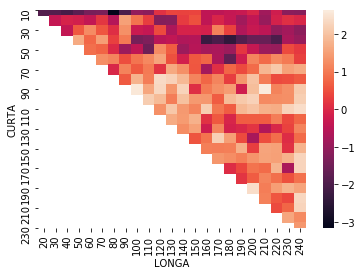

In [175]:

sns.heatmap(recente_sharpe.pivot('CURTA','LONGA','SHARPE'))

## Rendimento Puro

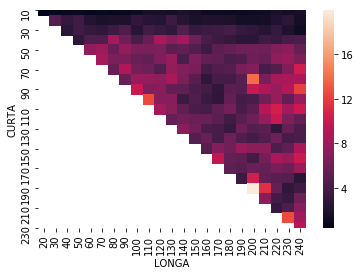

In [91]:
sns.heatmap(recent_results.pivot('CURTA','LONGA','RETORNO'))

In [93]:
#Vale notar o 80-200 e 90-240 proximos da regra de rua 50-200 para médias mopceuis
recent_results.sort_values(by='RETORNO')

,CURTA,LONGA,RETORNO
0,10,20,0.393170
6,10,80,0.733184
4,10,60,0.815979
1,10,30,0.842205
5,10,70,0.852969
...,...,...,...
170,90,240,12.217799
171,100,110,12.484577
273,220,230,12.646122
151,80,200,13.992715


In [96]:
recente_sharpe.sort_values(by='SHARPE')

,CURTA,LONGA,SHARPE
6,10,80,-3.151319
79,40,180,-2.405068
77,40,160,-2.267692
2,10,40,-2.082233
78,40,170,-2.019944
...,...,...,...
143,80,120,2.359837
261,190,200,2.411981
197,110,240,2.417414
156,90,100,2.567826


In [156]:
ibov=(data1['^BVSP']/65524)

In [167]:
results[[(90,210),(110,240),(190,200),(80,200)]]

,90,110,190,80
,210,240,200,200
Date,,,,
2010-02-01,1.000000,1.00000,1.000000,1.000000
2010-02-02,1.000000,1.00000,1.000000,1.000000
2010-02-03,1.000000,1.00000,1.000000,1.000000
2010-02-04,1.000000,1.00000,1.000000,1.000000
2010-02-05,1.000000,1.00000,1.000000,1.000000
...,...,...,...,...
2018-07-26,9.313983,10.03161,19.968324,14.384141
2018-07-27,9.262341,10.03161,19.968324,14.282487


In [170]:
perf_comp=pd.concat([results[[(90,210),(110,240),(190,200),(80,200)]],ibov],axis=1)

# Viés de seleção no período mais longo, talvez explosão de vlaor de emrpresas que só entratar depois no ibov

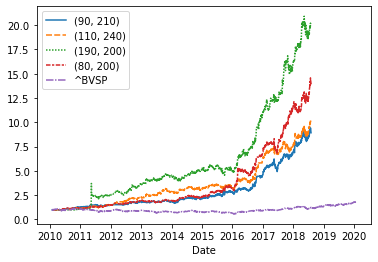

In [176]:
#Viés de seleção no período mais longo, talvez explosão de vlaor de emrpresas que só entratar depois no ibov
sns.lineplot(data=perf_comp)

In [100]:
valid={}
for i in [ (90,210),(190,200),(80,200)]:

    results=[td.stop_loss(td.calculate_returns(td.troca_posicao(td.estrategia_mmovel(data1[x],i[1] ,i[0]))),0.95) for  x in  data1.columns ]
    valid[i]=results

In [149]:
retornos=pd.concat(valid[(90,210)],axis=1)['DAILY_CHANGE']
pesos=pd.notnull(retornos[retornos.index>='2019-01-01']).sum(axis=1)

In [150]:
ibov=(data1['^BVSP'][data1.index>='2019-01-01']/91012)

In [151]:
novduz=((retornos.sum(axis=1)[retornos.index>='2019-01-01']/pesos).cumprod())

# (90,210) Dias

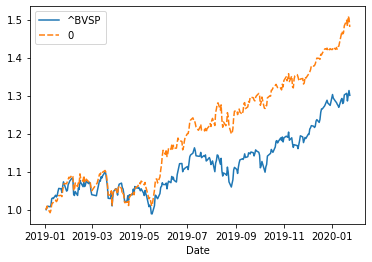

In [152]:
sns.lineplot(data=pd.concat([ibov,novduz],axis=1))

# (190,200) dias

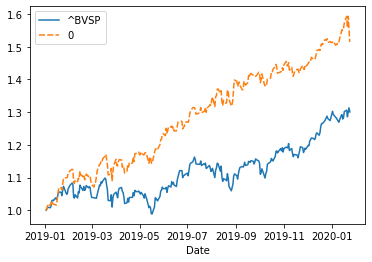

In [153]:
retornos=pd.concat(valid[(190,200)],axis=1)['DAILY_CHANGE']
pesos=pd.notnull(retornos[retornos.index>='2019-01-01']).sum(axis=1)
novduz=((retornos.sum(axis=1)[retornos.index>='2019-01-01']/pesos).cumprod())
sns.lineplot(data=pd.concat([ibov,novduz],axis=1))

# (80,200) Dias

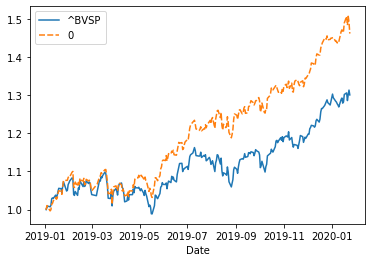

In [154]:

retornos=pd.concat(valid[(80,200)],axis=1)['DAILY_CHANGE']
pesos=pd.notnull(retornos[retornos.index>='2019-01-01']).sum(axis=1)
novduz=((retornos.sum(axis=1)[retornos.index>='2019-01-01']/pesos).cumprod())
sns.lineplot(data=pd.concat([ibov,novduz],axis=1))

## Performance Parece ser realmente boa com baixa vol problema é o numero de ativos na carteira, vou validar em tempo real e reporto de novo